In [0]:
import torch.nn as nn
import torch.nn.functional as F
import math

import pandas as pd
import seaborn as sns

class Autoencoder(nn.Module):

    def __init__(self):
        
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid())

    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x


In [10]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.distributions as tdist

# custom dataloader for .npy file
class numpyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x
    
    def __len__(self):
        return len(self.data)



def add_noise(img):
    noise = torch.randn(img.size()) * 0.0002
    noisy_img = img + noise
    
    return noisy_img

if __name__ == '__main__':

    NUM_EPOCH       =  200
    learning_rate   =  0.003
    
    loss_train_mean_arr = np.zeros(NUM_EPOCH, dtype=float)
    loss_train_std_arr = np.zeros(NUM_EPOCH, dtype=float)
    
    transform       = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor(),
                                ])

    
    # -----------------------------------------------------------------------------
    # load dataset
    # -----------------------------------------------------------------------------
    
    traindata       = np.load('./gdrive/My Drive/Colab Notebooks/train.npy')
    traindataset    = numpyDataset(traindata, transform)
    trainloader     = DataLoader(traindataset, batch_size=100, shuffle=False, num_workers=0)

    testdata        = np.load('./gdrive/My Drive/Colab Notebooks/test.npy')
    testdataset     = numpyDataset(testdata, transform)
    testloader      = DataLoader(testdataset, batch_size=1, shuffle=False, num_workers=0)
    
    
    # -----------------------------------------------------------------------------
    # load neural network model
    # -----------------------------------------------------------------------------
    
    model = Autoencoder().cuda()
    
    
    # -----------------------------------------------------------------------------
    # optimization algorithm
    # -----------------------------------------------------------------------------
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    
    # -----------------------------------------------------------------------------
    # iteration for the epoch
    # -----------------------------------------------------------------------------
    
    # for training
    model.train()
    
    for epoch in range(NUM_EPOCH):
        
        loss_train          = []
        
        for batch_idx, data in enumerate(trainloader):
            
            image   = data

            noisy_img = add_noise(image)
            noisy_img = Variable(noisy_img).cuda()
            image = Variable(image).cuda()

            output = model(noisy_img)
            loss = criterion(output, image)
            MSE_loss = nn.MSELoss()(output, image)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train_batch = loss.item() / len(data)
            loss_train.append(loss_train_batch)
            
        loss_train_mean = np.mean(loss_train)
        loss_train_std  = np.std(loss_train)
        loss_train_mean_arr[epoch]  = loss_train_mean
        loss_train_std_arr[epoch]   = loss_train_std
        
        print("[epoch {0}] loss: (training) {1}".format(epoch, round(loss_train_mean, 6)))
                  

    # for testing            
    model.eval()

    result_for_submit = None    # this is for submit file

    for batch_idx, data in enumerate(testloader):
        
        timage = data
        timage = Variable(timage).cuda()
        
        resimage = model(timage)
        result_of_test = resimage.cpu()
    
        if batch_idx == 0:
            result_for_submit = result_of_test
        else:
            try:
                result_for_submit = torch.cat([result_for_submit, result_of_test], dim=0)

            except RuntimeError:
                transposed = torch.transpose(result_of_test, 2, 3)
                result_for_submit = torch.cat([result_for_submit, transposed], dim=0)
        
    # the submit_file.shape must be (400,1,120,80) 
    submit_file = result_for_submit.detach().numpy()
    np.save('./gdrive/My Drive/Colab Notebooks/JangJaeYong.npy', submit_file)
                  

[epoch 0] loss: (training) 0.006702
[epoch 1] loss: (training) 0.00657
[epoch 2] loss: (training) 0.006565
[epoch 3] loss: (training) 0.00656
[epoch 4] loss: (training) 0.00656
[epoch 5] loss: (training) 0.006559
[epoch 6] loss: (training) 0.006566
[epoch 7] loss: (training) 0.006576
[epoch 8] loss: (training) 0.006549
[epoch 9] loss: (training) 0.006544
[epoch 10] loss: (training) 0.006548
[epoch 11] loss: (training) 0.006554
[epoch 12] loss: (training) 0.006544
[epoch 13] loss: (training) 0.006537
[epoch 14] loss: (training) 0.006535
[epoch 15] loss: (training) 0.006534
[epoch 16] loss: (training) 0.006532
[epoch 17] loss: (training) 0.00653
[epoch 18] loss: (training) 0.006531
[epoch 19] loss: (training) 0.006531
[epoch 20] loss: (training) 0.006531
[epoch 21] loss: (training) 0.006536
[epoch 22] loss: (training) 0.006536
[epoch 23] loss: (training) 0.006535
[epoch 24] loss: (training) 0.006534
[epoch 25] loss: (training) 0.006531
[epoch 26] loss: (training) 0.006528
[epoch 27] loss

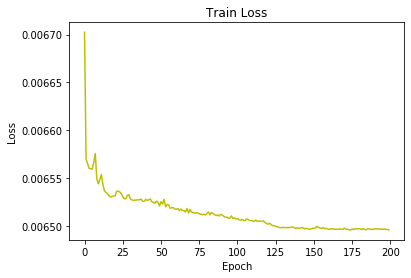

In [11]:
x = range(NUM_EPOCH)
y = loss_train_mean_arr[x]

plt.plot(x, y, color='y')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

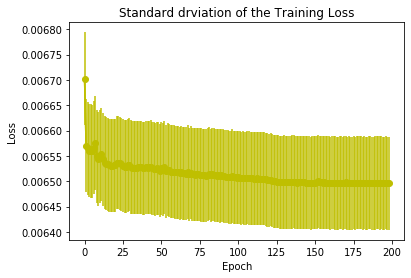

In [17]:
x = range(epoch)
y = sns.lineplot(data=loss_train_mean_arr[x], err_style="band", color='y')
std  = loss_train_std
y.errorbar(range(epoch), loss_train_mean_arr[x], yerr=std, fmt='-o', color='y')
plt.title('Standard drviation of the Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()